# Nuclei Finder

In this notebook, we will look at the training process for the UNET segmentation model used in Nuclei Finder. Training data was taken from the [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018). 

To start, we import our packages:

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from glob import glob

# Data preparation

First, we take a look at our data:

In [2]:
ls data

classes.csv           stage1_train-updated/
stage1_test/          stage2_test_final/


- `stage1_train-updated/` : This is the `stage1_train/` data from [Kaggle](https://www.kaggle.com/c/data-science-bowl-2018), but hand-corrected for segmentation errors in the masks. Thanks to [this repo](https://github.com/lopuhin/kaggle-dsbowl-2018-dataset-fixes) for the updated data!
- `stage1_test/` : This is the stage-1 testing data from [Kaggle](https://www.kaggle.com/c/data-science-bowl-2018). Since the competition is now over and the testing masks are released, I decided to use them all together to train the network. 
- `classes.csv` : This is a dataset of training and test data classes based on coarse modality information (white on dark background, dark on black, pink on purple, etc.). These classes were taken from [this thread](https://www.kaggle.com/c/data-science-bowl-2018/discussion/48130).

Let's see the total number of images in our combined training set:

In [3]:
st1_train_dir = 'data/stage1_train-updated/'
st1_test_dir = 'data/stage1_test/'

st1_train_ids = [path.split('/')[-1] for path in glob(st1_train_dir + '*')]
st1_test_ids = [path.split('/')[-1] for path in glob(st1_test_dir + '*')]

n_images = len(st1_train_ids + st1_test_ids)
print(f'Number of images: {n_images}')

Number of images: 729


We have 729 image/mask pairs across the two folders.

Now, we load all of the data together. For now, we load the images at full size and store them in lists for downstream processing.

In [4]:
train_data_raw = []
mask_data_raw = []
ID_raw = []
for st1_IDs,st1_dir in zip([st1_train_ids,st1_test_ids],[st1_train_dir,st1_test_dir]):
    for ID in st1_IDs:
        ID_raw.append(ID)
        img_fn = f'{st1_dir}{ID}/images/{ID}.png'
        train_data_raw.append(imread(img_fn))
    
        # Sum all masks to one image 
        mask_fns = glob(f'{st1_dir}{ID}/masks/*.png')
        mask_imgs = [imread(fn) for fn in mask_fns]
        mask_sum = np.sum(mask_imgs,0)
        mask_data_raw.append(mask_sum)

## Images -> tiles

It will be convenient during training to have all images be the same size of 128x128. Rather than scaling and resizing the raw data, we opt instead to separate each image into overlapping tiles of size 128x128. This way, no information is lost that could be useful to training and the size of our training set increases. 

First, we define shape constants for the rest of the notebook:

In [5]:
IMG_WIDTH=128
IMG_HEIGHT=128
IMG_CHANNELS=3

In [6]:
def img_to_tiles(img,tgt_shape):
    '''Takes a 2D ndarray image (img) and returns a list 
    of overlapping tiles of shape=tgt_shape'''
    tgt_h, tgt_w = tgt_shape
    img_h, img_w = img.shape[:2]
    
    nh_tiles = int(np.ceil(img_h / tgt_h))
    nw_tiles = int(np.ceil(img_w / tgt_w))
    
    if (nh_tiles*nw_tiles) == 1:  # return the image if it is already the right shape
        tiles = [img]
    else:    
        tiles = []
        for h in range(nh_tiles):
            if nh_tiles == 1:
                h_i = 0
                h_f = img_h
            else:
                h_i = int(h/(nh_tiles-1) * (img_h-tgt_h))
                h_f = int(h_i + tgt_h)
            for w in range(nw_tiles):
                if nw_tiles == 1:
                    w_i = 0
                    w_f = img_w
                else:
                    w_i = int(w/(nw_tiles-1)*(img_w-tgt_w))
                    w_f = int(w_i+tgt_w)
                tiles.append(img[h_i:h_f,w_i:w_f])
    return tiles

Below, we demonstrate the tiling process on a single image:

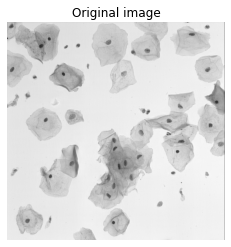

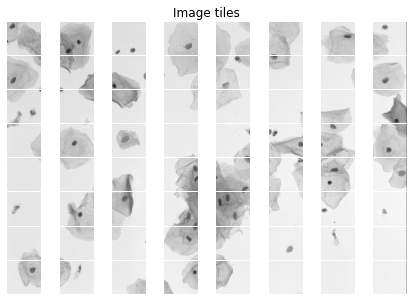

In [7]:
def clean_ax(ax):
    '''Utility function to clean imshow axes'''
    ax.set_aspect('equal')
    ax.axis('off')
    return ax

sample_img = train_data_raw[100]
tiles = img_to_tiles(sample_img,tgt_shape=(IMG_HEIGHT,IMG_WIDTH)) 

fig, ax = plt.subplots()
ax.imshow(sample_img)
ax.set_title('Original image')
clean_ax(ax);

fig, ax = plt.subplots(8,8)
counter = 0
for h in range(8):
    for w in range(8):
        ax[h,w].imshow(tiles[counter])
        clean_ax(ax[h,w])
        counter += 1
fig.suptitle('Image tiles',y=1)
fig.tight_layout(pad=0.1)

We will use this function to break our entire training set into NumPy arrays, keeping track of the IDs and masks as well:

In [8]:
X_tile_list = []  # image tiles
y_tile_list = []  # mask tiles
ID_tile_list = []  # IDs for each tile
for i in range(n_images):
    img = train_data_raw[i][...,:IMG_CHANNELS]
    img_tiles = img_to_tiles(img,tgt_shape=(IMG_HEIGHT,IMG_WIDTH))
    X_tile_list.extend(img_tiles)
    
    mask = mask_data_raw[i]
    mask_tiles = img_to_tiles(mask,tgt_shape=(IMG_HEIGHT,IMG_WIDTH))
    y_tile_list.extend(mask_tiles)
    
    ID_tile_list.extend([ID_raw[i]] * len(mask_tiles))
    
X_full = np.array(X_tile_list,dtype=np.uint8)
y_full = np.array(y_tile_list,dtype=bool)
y_full = np.expand_dims(y_full,-1)  # need empty dimension at the end
ID_full = np.array(ID_tile_list)

print(f'Original n_images: {n_images}')
print(f'New training tiles: {X_full.shape[0]}')

Original n_images: 729
New training tiles: 8034


## Create stratified validation set 

As mentioned earlier, there was helpful discussion on [this thread](https://www.kaggle.com/c/data-science-bowl-2018/discussion/48130) about class imbalances in the training set. Accordingly, we will create a stratified training and validation set making sure that the class distributions are comparable in each. This will help our model generaliize to different types of nuclei images.

In [9]:
# Read in class csv file
classes = pd.read_csv('data/classes.csv',index_col=0)

# Create new custom label from foreground/background label pair
classes['label'] = [f"{classes['foreground'][i]}-{classes['background'][i]}" for i in range(classes.shape[0])]

# Make array of unique labels
unique_class_labels = classes['label'].unique()

Here we use the ID index in `classes` to assign class labels to each of our tiles:

In [10]:
classes_full = np.array([classes.loc[ID + '.png']['label'] for ID in ID_full])

We can see the different types of classes and their counts here:

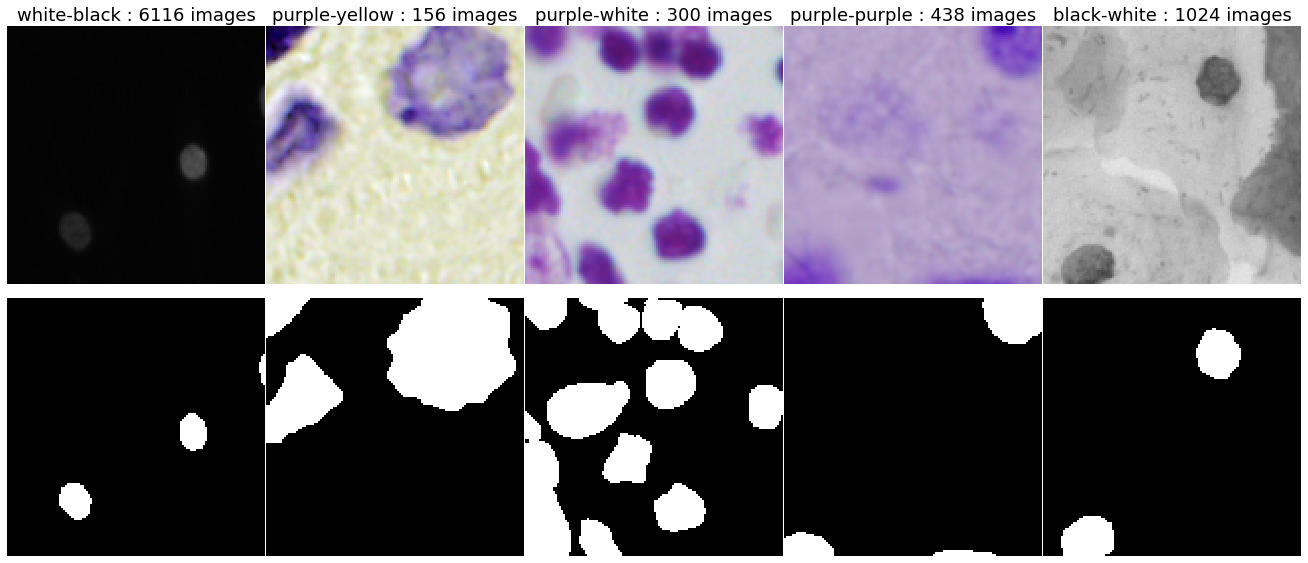

In [11]:
fig, ax = plt.subplots(2, unique_class_labels.size, figsize=(18,8))

for i, label in enumerate(unique_class_labels):
    n_label = np.sum(classes_full==label)    
    inds = np.where(classes_full==label)[0]
    np.random.seed(3)
    sample_ind = inds[np.random.randint(0,inds.size)]
    
    img = X_full[sample_ind]
    ax[0,i].imshow(img,interpolation='none')
    ax[0,i].set_title(f'{label} : {n_label} images',fontsize=18)
    ax[0,i] = clean_ax(ax[0,i])
    
    mask = y_full[sample_ind]
    ax[1,i].imshow(np.squeeze(mask),interpolation='none',cmap='gray')
    ax[1,i] = clean_ax(ax[1,i])
fig.tight_layout(pad=0.1)

Now we break our training data into training and validation arrays using a stratified random split to make sure the classes are balanced.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, 
                                                  train_size=0.9,
                                                  random_state=2021,
                                                  shuffle=True,
                                                  stratify=classes_full)

## Data augmentation

In this section, we perform additional data augmentation on the training data using random rotations, shifts, zooms, and flips. This gives our model more data to train with and improves generalizability by exposing it to more samples from a realistic data distribution. 

First we define the batch size as another global parameter:

In [13]:
BATCH_SIZE=32

Set some parameters for our augmented data generator:

In [14]:
seed = 2021
augment_dict = {
    'rotation_range' : 45,
    'width_shift_range' : 0.2,
    'height_shift_range' : 0.2,
    'zoom_range' : 0.2,
    'horizontal_flip' : True,
    'vertical_flip' : True,
    'fill_mode' : 'reflect'
}

And create separate data generators for the training and validation sets. Note that we do not augment the validation dataset to ensure that our measures of generalizability are as realistic as possible.

In [15]:
# Apply data augmentation to training data 
X_train_gen = ImageDataGenerator(**augment_dict)
y_train_gen = ImageDataGenerator(**augment_dict)

X_train_flow = X_train_gen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True,seed=seed)
y_train_flow = y_train_gen.flow(y_train,batch_size=BATCH_SIZE,shuffle=True,seed=seed)
train_generator = zip(X_train_flow, y_train_flow)

# Put validation data in generator without augmentation
X_val_gen = ImageDataGenerator()
y_val_gen = ImageDataGenerator()

X_val_flow = X_val_gen.flow(X_val,batch_size=BATCH_SIZE,shuffle=True,seed=seed)
y_val_flow = y_val_gen.flow(y_val,batch_size=BATCH_SIZE,shuffle=True,seed=seed)

val_generator = zip(X_val_flow, y_val_flow)

We can see sample results from our data augmentation below, with 5 iterations of the same base image and mask:

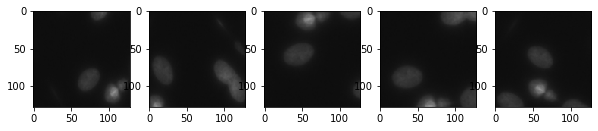

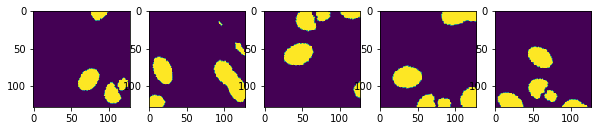

In [16]:
N = 5

xs = [X_train_flow[6][0] for x in range(N)]
ys = [y_train_flow[6][0] for y in range(N)]


fig, ax = plt.subplots(1,N,figsize=(10,2))
fig2, ax2 = plt.subplots(1,N,figsize=(10,2))
for i in range(N):
    ax[i].imshow(xs[i]/255,interpolation='none')
    ax2[i].imshow(ys[i]/255,interpolation='none')
    

# Model building

Here, we build our [UNET](https://en.wikipedia.org/wiki/U-Net) segmentation model. The model generation functions were inspired [here](https://idiotdeveloper.com/polyp-segmentation-using-unet-in-tensorflow-2/), and the overall architecture was inspired [here](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277).

In [17]:
def conv_block(x, num_filters, do=0.1,activation='elu'):
    '''Utility function to generate a convolution block'''
    x = Conv2D(num_filters, (3, 3), activation=activation, 
               kernel_initializer='he_normal',padding='same')(x)
    x = Dropout(do)(x)
    x = Conv2D(num_filters, (3, 3), activation=activation, 
               kernel_initializer='he_normal',padding='same')(x)
    return x

def build_model(input_size,num_filters=None,dropouts=None):
    '''Function to build a UNET model with a given input_size,
    list of num_filters, and list of dropout fractions.""'''
    if num_filters is None:
        num_filters = [16,32,64,128,256]
    if dropouts is None:
        dropouts = [0.1, 0.1, 0.2, 0.2, 0.3]
           
    # Input layer: scale to 0-1
    inputs = Input(input_size)
    x = Lambda(lambda x: x/255)(inputs)

    skip_x = []

    # Encoder
    for f, do in zip(num_filters[:-1],dropouts[:-1]):
        x = conv_block(x, f, do)
        skip_x.append(x)
        x = MaxPooling2D((2,2))(x)

    # Bridge
    x = conv_block(x, num_filters[-1],dropouts[-1])

    num_filters.reverse()
    dropouts.reverse()
    skip_x.reverse()

    # Decoder
    for i, (f, do) in enumerate(zip(num_filters[1:], dropouts[1:])):
        x = Conv2DTranspose(f, (2,2),strides=(2,2),padding='same')(x)
        xs = skip_x[i]
        x = concatenate([x,xs])
        x = conv_block(x, f, do)

    # Output
    outputs = Conv2D(1, (1,1), activation='sigmoid')(x)

    model = Model(inputs=[inputs],outputs=[outputs])
    return model

Here we build our model and tell it to report the "mean intersection over union" metric used commonly for segmentation tasks. We then print out a summary of the model:

In [18]:
model = build_model((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[tf.keras.metrics.MeanIoU(2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

Finally, we train the model using a number of `keras` callbacks:

- `earlystopper` : Stops the training if there is no improvement in validation loss over 3 epochs
- `checkpointer` : Saves the model along the way as the validation loss improves
- `lrschedule` : Changes the learning rate for later epochs

In [19]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr 
    else:
        return lr * tf.math.exp(-0.1)

earlystopper = EarlyStopping(patience=3, verbose=1, monitor='val_loss')
checkpointer = ModelCheckpoint('nuclei-segment.h5', verbose=1, save_best_only=True)
lrschedule = LearningRateScheduler(scheduler)
results = model.fit(train_generator,
                     validation_data=val_generator,
                     validation_steps=50, 
                     epochs=20, 
                     steps_per_epoch = len(X_train)//BATCH_SIZE,
                     callbacks=[earlystopper,checkpointer,lrschedule],
                     verbose=1)

Epoch 1/50
225/225 [==============================] - 42s 181ms/step - loss: 0.1612 - mean_io_u_82: 0.4341 - val_loss: 0.0901 - val_mean_io_u_82: 0.4280

Epoch 00001: val_loss improved from inf to 0.09010, saving model to nuclei-segment.h5
Epoch 2/50
225/225 [==============================] - 40s 180ms/step - loss: 0.0912 - mean_io_u_82: 0.4346 - val_loss: 0.0858 - val_mean_io_u_82: 0.4273

Epoch 00002: val_loss improved from 0.09010 to 0.08582, saving model to nuclei-segment.h5
Epoch 3/50
225/225 [==============================] - 40s 179ms/step - loss: 0.0818 - mean_io_u_82: 0.4340 - val_loss: 0.0758 - val_mean_io_u_82: 0.4275

Epoch 00003: val_loss improved from 0.08582 to 0.07577, saving model to nuclei-segment.h5
Epoch 4/50
225/225 [==============================] - 41s 182ms/step - loss: 0.0764 - mean_io_u_82: 0.4344 - val_loss: 0.0739 - val_mean_io_u_82: 0.4285

Epoch 00004: val_loss improved from 0.07577 to 0.07390, saving model to nuclei-segment.h5
Epoch 5/50
225/225 [========

# Evaluation

To test that our model is working, we predict the nuclei masks on the validation dataset and visualize results

In [20]:
preds = model.predict(X_val, verbose=1)
preds_t = (preds > 0.5).astype(np.uint8)

26/26 [==============================] - 17s 668ms/step


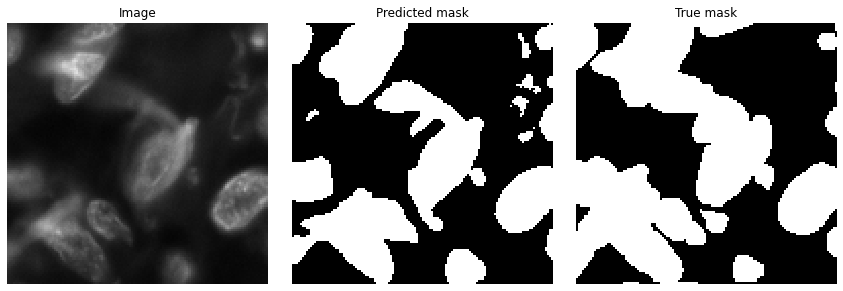

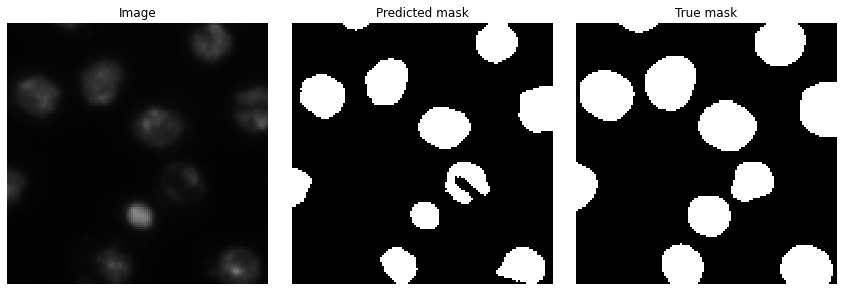

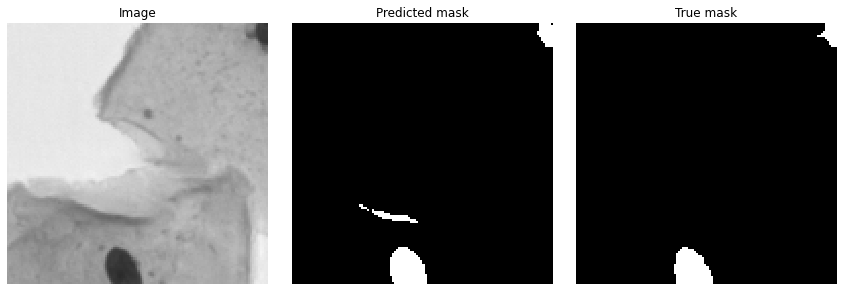

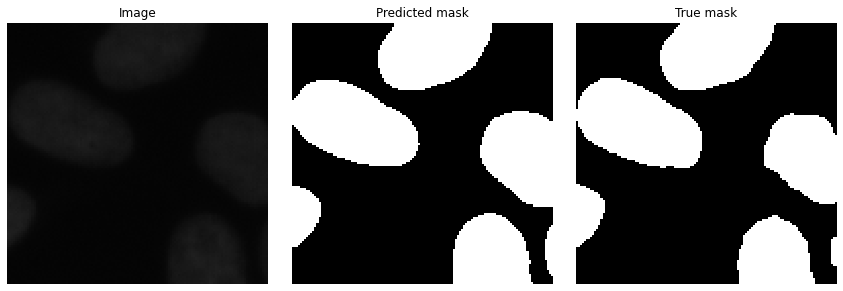

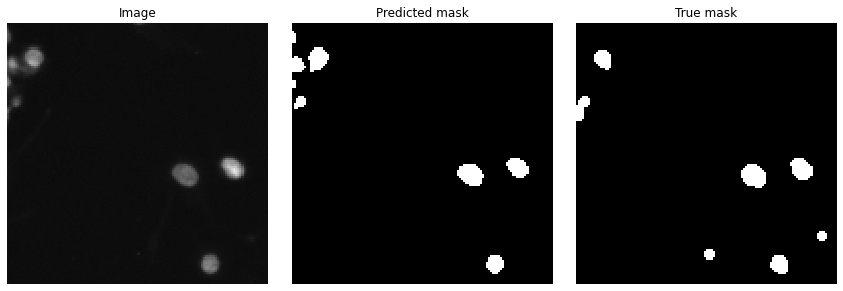

In [21]:
np.random.seed(20)
inds = np.random.randint(0,X_val.shape[0], size=5)

for ind in inds:
    fig, ax = plt.subplots(1,3,figsize=(12,4))

    ax[0].imshow(X_val[ind],interpolation='none')
    clean_ax(ax[0])
    ax[0].set_title('Image')

    ax[1].imshow(np.squeeze(preds_t[ind]),cmap='gray',interpolation='none')
    clean_ax(ax[1])
    ax[1].set_title('Predicted mask')

    ax[2].imshow(np.squeeze(y_val[ind]),cmap='gray',interpolation='none')
    clean_ax(ax[2])
    ax[2].set_title('True mask')
    fig.tight_layout()